In [4]:
import argparse
from pathlib import Path
from data_processing import DataProcessor
from models import ModelTrainer
from feature_selection import FeatureSelector
from visualization import Visualizer
from causal_inference import CausalInference
import shap
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib
from evaluation import iterative_feature_deletion_with_rmse, iterative_feature_addition_with_rmse

import warnings
warnings.filterwarnings("ignore")



In [5]:
print("Starting ML Pipeline...")
base_dir = '../../../'
print(f"Base directory set to: {base_dir}")

data_path = base_dir + 'dataset/' + 'data_full.xlsx'
raw_data_path = base_dir + 'dataset/' + 'result_raw.xlsx'
result_dir = base_dir + 'result/R/'

report_file_path = result_dir + 'report.txt'

print("Loading data...")
data_processor = DataProcessor(data_path=str(data_path))
df = data_processor.load_data_metabolites()
print("Data loaded successfully.")

Starting ML Pipeline...
Base directory set to: ../../../
Loading data...
Data loaded successfully.


In [6]:
print("Preprocessing raw data...")
raw_df = data_processor.preprocess_raw_data(raw_data_path=str(raw_data_path))
print("Raw data preprocessed successfully.")

print("Encoding labels...")
df_encoded, label_encoder = data_processor.encode_labels(df, label_column='Group')
print("Labels encoded successfully.")

X = df_encoded.drop(columns=['Group'])
y = df_encoded['Group']

print("Training Random Forest model...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}
model_trainer = ModelTrainer(X, y)
model, best_params = model_trainer.train_random_forest(param_dist)
print("Model trained successfully.")

Preprocessing raw data...
Raw data preprocessed successfully.
Encoding labels...
Labels encoded successfully.
Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Model trained successfully.


In [7]:
print("Evaluating model...")
accuracy, report = model_trainer.evaluate_model()
print(accuracy)
print(report)
print("Model evaluation completed.")

print("Saving trained model...")
model_trainer.save_model(str(result_dir + 'best_random_forest_model.pkl'))
print("Model saved successfully.")



Evaluating model...
0.8378378378378378
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        26
           1       0.80      1.00      0.89        48

    accuracy                           0.84        74
   macro avg       0.90      0.77      0.79        74
weighted avg       0.87      0.84      0.82        74

Model evaluation completed.
Saving trained model...
Model saved successfully.


In [8]:
predicted_probabilities = model.predict_proba(X)

prob_df = pd.DataFrame(predicted_probabilities, columns=[f'Prob_Class_{i}' for i in range(predicted_probabilities.shape[1])])

result_df = pd.concat([X.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)

result_df.to_excel('data_full_predicted_probabilities.xlsx', index=False)

print("Predicted probabilities exported successfully to 'predicted_probabilities.xlsx'.")


Predicted probabilities exported successfully to 'predicted_probabilities.xlsx'.


In [9]:
print("Performing feature selection using Gini importance...")
feature_selector = FeatureSelector(model, model_trainer.X_train)
selected_features_gini = feature_selector.gini_importance(threshold=0.001)
sorted_features = selected_features_gini.sort_values(ascending=False)

top_30_features = sorted_features.head(30)

print("Top 30 features selected based on Gini importance:")
print(top_30_features.to_list())


Performing feature selection using Gini importance...
Top 30 features selected based on Gini importance:
['xylose', 'xanthosine', 'valylglutamine', 'valine betaine', 'ursodeoxycholate sulfate (1)', 'uracil', 'tyrosine', 'tryptophylglycine', "trigonelline (N'-methylnicotinate)", 'tricarballylate', 'thymine', 'threonine', 'thiamin (Vitamin B1)', 'theobromine', 'syringic acid', 'succinimide', 'succinate', 'stearate (18:0)', 'stachydrine', 'sphingosine', 'serotonin', 'serine', 'salicylate', 'saccharin', 'ribulose/xylulose', 'riboflavin (Vitamin B2)', 'ribitol', 'quinolinate', 'quinate', 'pyroglutamine*']


In [10]:
X = X[['xylose', 'xanthosine', 'valylglutamine', 'valine betaine', 'ursodeoxycholate sulfate (1)', 'uracil', 'tyrosine', 'tryptophylglycine', "trigonelline (N'-methylnicotinate)", 'tricarballylate', 'thymine', 'threonine', 'thiamin (Vitamin B1)', 'theobromine', 'syringic acid', 'succinimide', 'succinate', 'stearate (18:0)', 'stachydrine', 'sphingosine', 'serotonin', 'serine', 'salicylate', 'saccharin', 'ribulose/xylulose', 'riboflavin (Vitamin B2)', 'ribitol', 'quinolinate', 'quinate', 'pyroglutamine*']]
y = df_encoded['Group']

print("Training Random Forest model...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}
model_trainer = ModelTrainer(X, y)
model, best_params = model_trainer.train_random_forest(param_dist)

Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [11]:
print("Evaluating model...")
accuracy, report = model_trainer.evaluate_model()
print(accuracy)
print(report)
print("Model evaluation completed.")

print("Saving trained model...")
model_trainer.save_model(str(result_dir + 'best_random_forest_model.pkl'))
print("Model saved successfully.")



Evaluating model...
0.8108108108108109
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        26
           1       0.79      0.96      0.87        48

    accuracy                           0.81        74
   macro avg       0.83      0.75      0.77        74
weighted avg       0.82      0.81      0.80        74

Model evaluation completed.
Saving trained model...
Model saved successfully.


In [12]:
print("Applying TreeSHAP for explainability...")

# Use KMeans background data for SHAP Tree Explainer
explainer = shap.TreeExplainer(model, model_trainer.X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(model_trainer.X_test)

Applying TreeSHAP for explainability...


In [13]:
print("Applying Kernel SHAP for explainability...")

# Use KMeans background data for SHAP Kernel Explainer
background_data = shap.kmeans(model_trainer.X_train, 100)
explainer = shap.KernelExplainer(model.predict_proba, background_data)

# Calculate SHAP values
shap_values = explainer.shap_values(model_trainer.X_test)

Applying Kernel SHAP for explainability...


  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.26112397, 0.13522491, 0.09348883, 0.07281341, 0.06058076,
       0.05258747, 0.04703475, 0.04302611, 0.04006664, 0.03786298,
       0.03623251, 0.03505831, 0.03426514, 0.03380623, 0.01682799])
DEBUG:shap:num_subset_sizes = 15
DEBUG:shap:num_paired_subset_sizes = 14
DEBUG:shap:self.M = 30
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(60.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(870.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
INFO:shap:num_full_subsets = 1
DEBUG:shap:samples_left = 2048
INFO:shap:remaining_weight_vector = array([0.17893899, 0.1237109 , 0.09635176, 0.08016467, 0.06958738,
       0.06223965, 0.05

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\snorl\\Desktop\\FYP\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\snorl\\Desktop\\FYP\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Use

[[ 7.42557436e-02 -9.70899262e-04  1.14429132e-02 ... -2.35801984e-03
   1.77824254e-02 -3.15267561e-03]
 [ 9.79881920e-02  9.91082307e-05  9.53792652e-04 ... -6.63463870e-04
  -7.27050419e-03 -4.65230175e-03]
 [ 7.56656684e-02 -2.21118397e-03 -8.57258813e-04 ...  9.41862923e-04
   1.84395695e-02 -1.60622590e-03]
 ...
 [ 8.13690927e-02 -9.17978567e-03 -2.90645320e-03 ...  5.12836132e-04
  -3.92751308e-03 -1.08492632e-02]
 [-9.00357231e-02 -3.12786695e-03 -1.94346986e-03 ...  1.35560012e-03
  -3.05798637e-02  2.90829560e-03]
 [-9.83193380e-02  4.09855582e-03 -3.21358139e-04 ... -2.03180879e-03
  -2.03756752e-02  4.72902369e-03]]


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERTIBD.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\JUICE___.TTF', name='Juice ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=4

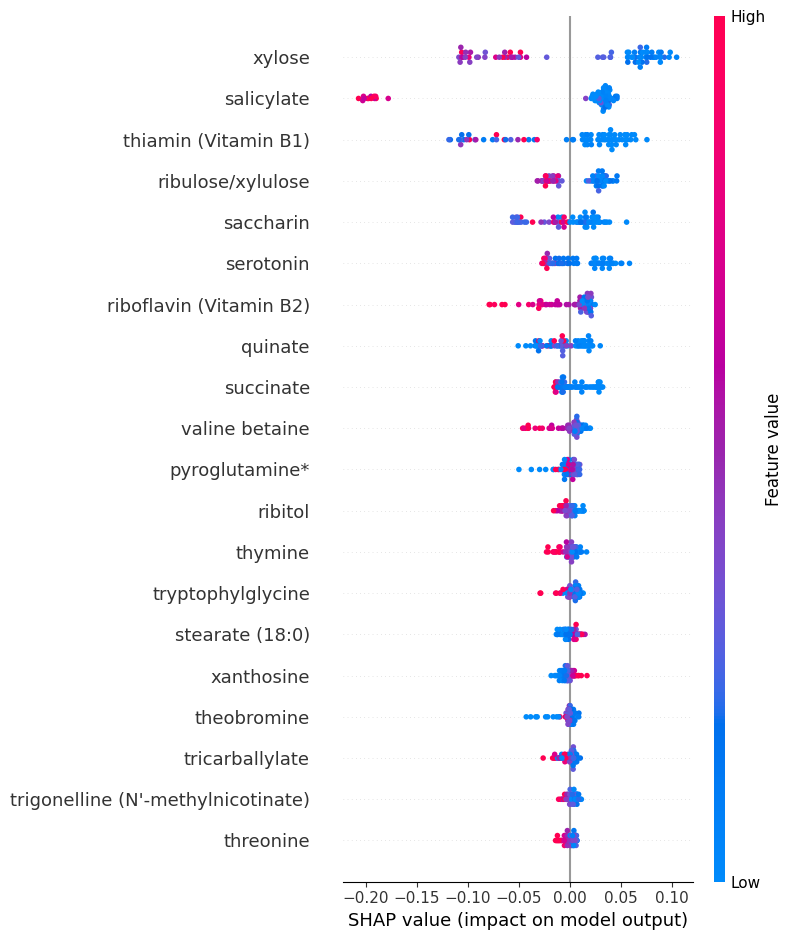

In [14]:
# Plot SHAP summary
shap_values_class1 = shap_values[:, :, 1]  # Shape: (74, 30)
print(shap_values_class1)
shap.summary_plot(shap_values[:,:,1], model_trainer.X_test)

In [15]:
model_trainer.X_test.head()

,xylose,xanthosine,valylglutamine,valine betaine,ursodeoxycholate sulfate (1),uracil,tyrosine,tryptophylglycine,trigonelline (N'-methylnicotinate),tricarballylate,thymine,threonine,thiamin (Vitamin B1),theobromine,syringic acid,succinimide,succinate,stearate (18:0),stachydrine,sphingosine,serotonin,serine,salicylate,saccharin,ribulose/xylulose,riboflavin (Vitamin B2),ribitol,quinolinate,quinate,pyroglutamine*
165,2.506056e+06,392215.1875,227777.3594,84891.79688,8.238643e+06,38972908.00,235692128.0,123408.1016,4.211854e+05,1.387354e+08,1.171533e+07,304798496.0,15661462.0,1.027740e+07,2.841786e+06,334771.2500,6.668248e+07,12877816832,2.851308e+07,7.373510e+06,8.522013e+05,1.547638e+08,2.312892e+05,4.472932e+05,297346.34380,3013518.250,35020.77340,138271.3064,5.401290e+06,9.703382e+05
33,1.054350e+06,413790.6951,990336.8947,71326.02586,4.607571e+07,17865980.13,158163385.5,345508.3051,7.068979e+05,6.845647e+07,5.197115e+06,228318193.8,178348372.5,1.830969e+06,1.583256e+05,807508.0433,8.734555e+07,2561052475,1.428820e+07,1.094444e+07,3.602409e+05,5.808115e+07,1.687328e+06,6.814437e+06,313931.91410,2218333.136,114038.06430,311079.9309,8.145667e+07,9.047389e+06
15,5.419032e+04,359696.5781,264627.3886,192954.82240,5.113608e+07,14872194.92,132402821.3,133474.4423,2.172100e+06,4.054795e+07,4.452226e+06,214612714.8,800421954.7,3.519177e+07,1.824419e+06,470228.0134,4.874515e+07,2493179412,7.738272e+06,1.147529e+06,8.540763e+05,9.135119e+07,2.904279e+05,2.037487e+05,69733.35278,2343550.737,95413.27579,271669.6345,9.374524e+06,3.553353e+06
312,1.264503e+07,227669.1992,204874.6123,84924.85914,2.823080e+07,25795284.91,352853919.2,130915.0340,1.444508e+07,2.603862e+07,1.266922e+07,569395166.9,173618373.7,6.302863e+06,7.535628e+04,569506.8970,1.088086e+08,2855278058,8.426676e+07,3.529341e+07,4.933513e+06,2.322843e+08,1.159479e+07,4.224602e+06,833316.39050,2826606.269,48387.22763,211656.7214,1.590875e+08,1.229582e+06
57,1.552786e+06,354748.1563,178436.8920,19341.44730,8.116564e+06,54136692.00,200438096.0,165364.4522,2.381670e+07,7.633326e+07,3.496956e+07,333888480.0,30830192.0,4.433828e+06,1.045041e+05,423964.5000,2.412612e+08,3469465856,1.123696e+07,2.294130e+07,6.354268e+06,9.058383e+07,3.112571e+06,2.586710e+05,626175.00000,3298984.750,187799.87500,160499.2031,3.048202e+06,1.551921e+06


In [16]:
print(shap_values[:][:][1][:,1])

[ 9.79881920e-02  9.91082307e-05  9.53792652e-04  7.42632535e-03
  9.75150198e-04  6.04544870e-03  5.34583689e-04 -1.70445441e-03
  3.68484545e-03  3.15630664e-03  3.62727943e-03  3.69183818e-03
 -6.31835994e-02  2.34341779e-03  1.04459171e-03  3.16563675e-04
  4.95732995e-03 -2.90368383e-03  8.15931235e-04 -1.04647143e-03
  3.63791224e-02 -2.23998179e-04  4.58607558e-02 -2.06321840e-02
  4.55255242e-02  1.81702535e-02 -1.02252640e-02 -6.63463870e-04
 -7.27050419e-03 -4.65230175e-03]


## Using the Predicted Probability for the PC to find Causal Edge that is directed to 'Group'

In [17]:
X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

print("Training Random Forest model...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}
model_trainer = ModelTrainer(X, y)
model, best_params = model_trainer.train_random_forest(param_dist)

Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [18]:
print("Evaluating model...")
accuracy, report = model_trainer.evaluate_model()
print(accuracy)
print(report)
print("Model evaluation completed.")

print("Saving trained model...")
model_trainer.save_model(str(result_dir + 'best_random_forest_model.pkl'))
print("Model saved successfully.")



Evaluating model...
0.8108108108108109
              precision    recall  f1-score   support

           0       0.77      0.65      0.71        26
           1       0.83      0.90      0.86        48

    accuracy                           0.81        74
   macro avg       0.80      0.77      0.78        74
weighted avg       0.81      0.81      0.81        74

Model evaluation completed.
Saving trained model...
Model saved successfully.


Applying SHAP for explainability...


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x0000020886E1E420>


[[ 0.11486443  0.00215567 -0.00492032 ...  0.00259128  0.00904321
   0.00863349]
 [ 0.10000743  0.00203317  0.00230973 ... -0.00419223  0.06047792
  -0.04543462]
 [ 0.07868715 -0.00294276  0.00325913 ...  0.00361019  0.00143554
  -0.00804236]
 ...
 [ 0.10458976 -0.00627233 -0.00065106 ...  0.00192314 -0.01925262
   0.01460433]
 [-0.13420773 -0.01879415 -0.00743571 ... -0.02944572  0.10006502
  -0.0198078 ]
 [-0.16033108  0.00603943  0.0112974  ... -0.00786244 -0.05561119
  -0.02222319]]


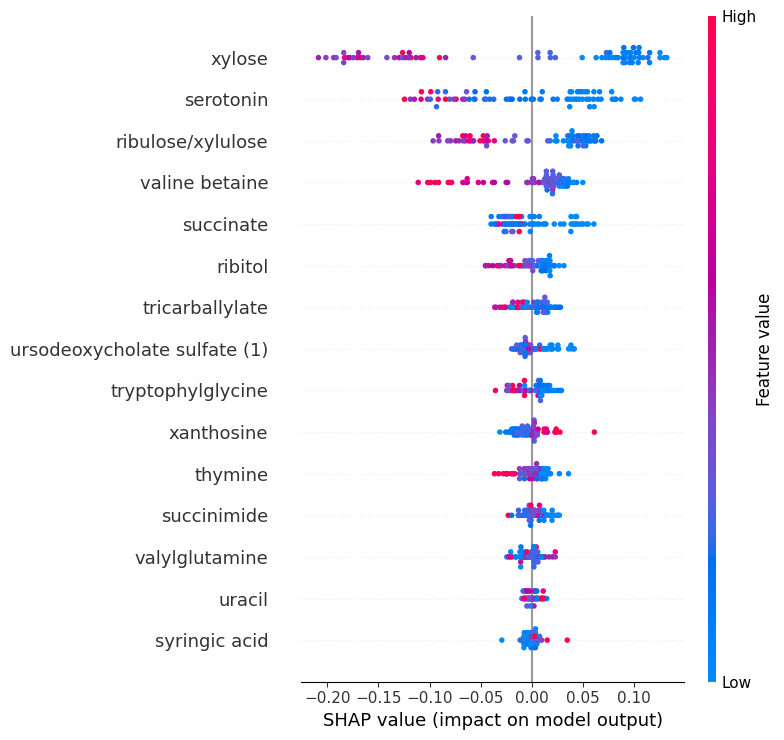

In [19]:
print("Applying SHAP for explainability...")

# Use KMeans background data for SHAP Kernel Explainer
explainer = shap.TreeExplainer(model, model_trainer.X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(model_trainer.X_test)

# Plot SHAP summary
shap_values_class1 = shap_values[:, :, 1]  # Shape: (74, 30)
print(shap_values_class1)
shap.summary_plot(shap_values[:,:,1], model_trainer.X_test)

In [20]:
from causal_inference import CausalInference

In [21]:
i = 0 # Example test instance
# SHAP sum and model prediction comparison

shap_sum = np.sum(shap_values[:][:][i][:,1]) + explainer.expected_value
model_prediction = model.predict_proba(model_trainer.X_test.iloc[i].values.reshape(1, -1))[0][1]

print(f"Expected Value: {explainer.expected_value}")

print(f"Model prediction: {model_prediction}")
print(f"Sum of SHAP values + expected value: {shap_sum}")

if np.isclose(shap_sum[1], model_prediction, atol=1e-6):
    print("SHAP sum matches the model prediction.")
else:
    print("Discrepancy between SHAP sum and model prediction.")

Expected Value: [0.35825431 0.64174569]
Model prediction: 0.8782824507867614
Sum of SHAP values + expected value: [0.59479107 0.87828245]
SHAP sum matches the model prediction.


In [22]:
print("Applying causal SHAP values...")
ci = CausalInference(data=model_trainer.X_train, model=model, target_variable='Prob_Class_1')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS.json')
print(ci.gamma)
X_train_scaled_df = pd.DataFrame(model_trainer.X_train, columns=model_trainer.X_train.columns)
X_test_scaled_df = pd.DataFrame(model_trainer.X_test, columns=model_trainer.X_test.columns)

Applying causal SHAP values...
{'xylose': 0.21286483817631863, 'xanthosine': 0.02394692431616487, 'uracil': 0.09473882478767023, 'ribulose/xylulose': 0.1846557343833871, 'valylglutamine': 0.006014187808621013, 'tryptophylglycine': 0.010263874030019977, 'succinate': 0.05945970043865379, 'valine betaine': 0.11760414785893997, 'ursodeoxycholate sulfate (1)': 0.0019060014073747102, 'tricarballylate': 0.0036239283407113083, 'succinimide': 0.018407825414330586, 'thymine': 0.08182038074786072, 'syringic acid': 0.004553557947259814, 'serotonin': 0.1350346545925681, 'ribitol': 0.0451054197501192}


In [23]:
x_instance = pd.Series(X_test_scaled_df.iloc[i], index=X_test_scaled_df.columns)
phi_normalized = ci.compute_modified_shap_proba(x_instance)

# Print modified SHAP values
print("Modified Causal SHAP Values:")
for feature, value in phi_normalized.items():
    print(f"{feature}: {value}")

Modified Causal SHAP Values:
xylose: 0.13225397406207984
xanthosine: -0.0029053634832192075
uracil: 0.010855010703359426
ribulose/xylulose: 0.12729433964303247
valylglutamine: -0.0004056528330309809
tryptophylglycine: 0.0010018551608491394
succinate: 0.00584595653445039
valine betaine: -0.002642197284198119
ursodeoxycholate sulfate (1): -0.0001459521197652923
tricarballylate: 0.00019075913178059008
succinimide: 0.0037575690437436165
thymine: 0.005118826204316526
syringic acid: 0.000631230148497586
serotonin: -0.01461428163472704
ribitol: -0.0038996318229844347


In [24]:
i = 30
x_instance = pd.Series(X_test_scaled_df.iloc[i], index=X_test_scaled_df.columns)
phi_normalized = ci.compute_modified_shap_proba(x_instance)

# Print modified SHAP values
print("Modified Causal SHAP Values:")
for feature, value in phi_normalized.items():
    print(f"{feature}: {value}")

Modified Causal SHAP Values:
xylose: 0.11311892270392937
xanthosine: -0.001397362104218143
uracil: -0.010857293780255952
ribulose/xylulose: 0.1001839486248588
valylglutamine: -0.0005100126588998503
tryptophylglycine: -0.0007034691256101514
succinate: -0.019074634629714073
valine betaine: 0.0105829258159314
ursodeoxycholate sulfate (1): -8.049816247962688e-05
tricarballylate: 0.00025568023672479644
succinimide: 0.0007743904165757363
thymine: 0.009957546559174616
syringic acid: 0.0005421396914991889
serotonin: 0.05979818392746521
ribitol: 0.0012993817383004785


In [25]:
# Compare standard SHAP and causal SHAP values
standard_shap_series = pd.Series(shap_values[i][:,1], index=X_test_scaled_df.columns)
causal_shap_series = pd.Series(phi_normalized, index=X_test_scaled_df.columns)
y_predicted = model.predict(X_test_scaled_df.iloc[i].values.reshape(1, -1))
print(f"Instance: {i}")
print(f"Instance Predicted Value: {y_predicted}")

# Apply iterative feature deletion and addition to compare SHAP values
print("Comparing SHAP and Causal SHAP using feature deletion and addition...")
avg_output_standard_deletion = iterative_feature_deletion_with_rmse(
    model=model, input_features=x_instance, attribution_scores=standard_shap_series, y_predicted=y_predicted, top_k=10)

avg_output_causal_deletion = iterative_feature_deletion_with_rmse(
    model=model, input_features=x_instance, attribution_scores=causal_shap_series, y_predicted=y_predicted, top_k=10)

avg_output_standard_addition = iterative_feature_addition_with_rmse(
    model=model, input_features=x_instance, attribution_scores=standard_shap_series, y_predicted=y_predicted, top_k=10)

avg_output_causal_addition = iterative_feature_addition_with_rmse(
    model=model, input_features=x_instance, attribution_scores=causal_shap_series, y_predicted=y_predicted, top_k=10)

print(f"Average RMSE (Standard SHAP - Deletion): {avg_output_standard_deletion}")
print(f"Average RMSE (Causal SHAP - Deletion): {avg_output_causal_deletion}")
print(f"Average RMSE (Standard SHAP - Addition): {avg_output_standard_addition}")
print(f"Average RMSE (Causal SHAP - Addition): {avg_output_causal_addition}")


Instance: 30
Instance Predicted Value: [1]
Comparing SHAP and Causal SHAP using feature deletion and addition...
Average RMSE (Standard SHAP - Deletion): 0.18007532467532458
Average RMSE (Causal SHAP - Deletion): 0.22204404761904759
Average RMSE (Standard SHAP - Addition): 0.17516480880230884
Average RMSE (Causal SHAP - Addition): 0.19388733766233773


#### Archive

In [26]:
# print("Performing feature selection using SHAP importance...")
# selected_features_shap = feature_selector.shap_importance(model_trainer.X_test, threshold=0.005)
# print("Feature selection (SHAP importance) completed.")

# print("Generating SHAP summary plot...")
# visualizer = Visualizer()
# shap_summary_path = result_dir + 'shap_summary.png'
# visualizer.plot_shap_summary(model, model_trainer.X_test, str(shap_summary_path))
# print(f"SHAP summary plot saved at: {shap_summary_path}")

# print("Performing causal inference...with SHAP selected and Group")
# causal_features = selected_features_shap.to_list() + ['Group']
# df_causal = df_encoded[causal_features]
# causal_inference = CausalInference(df_causal)
# causal_graph = causal_inference.run_pc_algorithm()
# print("Causal inference completed.")

# print("Drawing causal graph...")
# causal_graph_path = result_dir + 'causal_graph.png'
# causal_inference.draw_graph(str(causal_graph_path))
# print(f"Causal graph saved at: {causal_graph_path}")

# print("Writing report...")
# with open(report_file_path, 'w') as report_file:
#     report_file.write("First few rows of the dataset:\n")
#     report_file.write(df.head().to_string())
#     report_file.write("\n\n")
#     report_file.write("Best Parameters:\n")
#     report_file.write(str(best_params))
#     report_file.write("\n\n")
#     report_file.write(f"Accuracy: {accuracy * 100:.2f}%\n\n")
#     report_file.write("Classification Report:\n")
#     report_file.write(report)
#     report_file.write("\n\n")
#     report_file.write("Selected Features (Gini Importance):\n")
#     report_file.write(', '.join(selected_features_gini))
#     report_file.write("\n\n")
#     report_file.write("Selected Features (SHAP Importance):\n")
#     report_file.write(', '.join(selected_features_shap))
#     report_file.write("\n\n")
#     report_file.write(f"SHAP summary plot saved as '{shap_summary_path}'.\n\n")
#     report_file.write(f"Causal graph saved as '{causal_graph_path}'.\n")
# print("Report written successfully.")

# print(f"Report generated at '{report_file_path}'.")
# print("Process completed successfully.")
